# Example 1: Running RFLO

Created: November 15, 2021

The following notebook creates a vanilla RNN and trains it on a center-out "reach" task

# Jasmine's notes / questions
- why does target y not have a timecourse?
- why is shape(n_pos) n_out x 1 -- what is the 1? (asking bc it makes target out duration x shape(n_pos), not sure what the 1 is for)\

##
- changed the error in rflo, may need to do with other learning rules, will need to test the other learning rules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

In [3]:
from psychrnnEdit.tasks.perceptual_discrimination import PerceptualDiscrimination
from psychrnnEdit.backend.curriculum import Curriculum, default_metric

pds = [PerceptualDiscrimination(dt = 10, tau = 100, T = 2000, N_batch = 1, coherence = .7 - i/5) for i in range(4)]

metric = default_metric # Function for calculating whether the stage advances and what the metric value is at each metric_epoch. Default: default_metric().
accuracies = [pds[i].accuracy_function for i in range(len(pds))] # optional list of functions to use to calculate network performance for the purposes of advancing tasks. Used by default_metric() to compute accuracy. Default: [tasks[i].accuracy_function for i in range(len(tasks))].
thresholds = [.9 for i in range(len(pds))] # Optional list of thresholds. If metric = default_metric, accuracies must reach the threshold for a given stage in order to advance to the next stage. Default: [.9 for i in range(len(tasks))]
metric_epoch = 1 # calculate the metric / test if advance to the next stage every metric_epoch training epochs.
output_file = None # Optional path to save out metric value and stage to. Default: None.

curriculum = Curriculum(pds, output_file=output_file, metric_epoch=metric_epoch, thresholds=thresholds, accuracies=accuracies, metric=metric)

### Initialize Vanilla RNN

The `RNNparams` object stores the parameters, and is passed to the RNN

Note that we do not have any driving feedback

In [4]:
params = RNNparams(n_in=2, n_rec=5,n_out=2,tau_rec=10,
                   eta_in=0.1,eta_rec=0.1,eta_out=0.1,
                   sig_in=0.0,sig_rec=0.0,sig_out=0.01,
                   rng=np.random.RandomState(14))

print('\nannotations',params.__annotations__)
print('\nparams as dict',dataclasses.asdict(params))

net = RNN(params)
net.initialize_weights()
print('\nrecurrent weights',net.w_rec)


annotations {'n_in': <class 'int'>, 'n_rec': <class 'int'>, 'n_out': <class 'int'>, 'sig_in': <class 'float'>, 'sig_rec': <class 'float'>, 'sig_out': <class 'float'>, 'tau_rec': <class 'float'>, 'dt': typing.Optional[float], 'eta_in': typing.Optional[float], 'eta_rec': typing.Optional[float], 'eta_out': typing.Optional[float], 'g_in': typing.Optional[float], 'g_rec': typing.Optional[float], 'g_out': typing.Optional[float], 'g_fb': typing.Optional[float], 'driving_feedback': <class 'bool'>, 'eta_fb': typing.Optional[float], 'sig_fb': typing.Optional[float], 'feedback_signal': typing.Optional[str], 'velocity_transform': <class 'bool'>, 'tau_vel': typing.Optional[float], 'dt_vel': typing.Optional[float], 'sig_rec_dim': typing.Optional[int], 'eta_m': typing.Optional[float], 'sig_m': typing.Optional[float], 'lam_m': typing.Optional[float], 'rng': RandomState(MT19937) at 0x156BCAA40}

params as dict {'n_in': 2, 'n_rec': 5, 'n_out': 2, 'sig_in': 0.0, 'sig_rec': 0.0, 'sig_out': 0.01, 'tau_rec

### Create an example Task

Here the task is simply to reach the target at (1,1) given a pulse of trial 20 steps that lasts for 50% of the trial duration (i.e. 10 steps)

trial_duration = 20
n_in=1
frac_on = 0.5
y_target_x = np.expand_dims(np.concatenate((np.zeros(int(trial_duration*frac_on)),np.linspace(0,1,int(trial_duration*(1-frac_on))))),axis=1)
y_target_y = np.expand_dims(np.concatenate((np.zeros(int(trial_duration*frac_on)),np.linspace(0,1,int(trial_duration*(1-frac_on))))),axis=1)
y_teaching_signal = np.concatenate((y_target_x,y_target_y),axis=1)

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1

plt.plot(x_pulse1)
plt.title('Input Signal')
plt.xlabel('Steps (AU)')
plt.ylabel('Amplitude')
plt.show()

task = Task(x_in=x_pulse1,y_target=np.asarray([1,1]))
print('trial duration =',task.trial_duration)

### Train an RNN on a single target using RFLO

Note here that we are only learning the recurrent weights `w_rec`

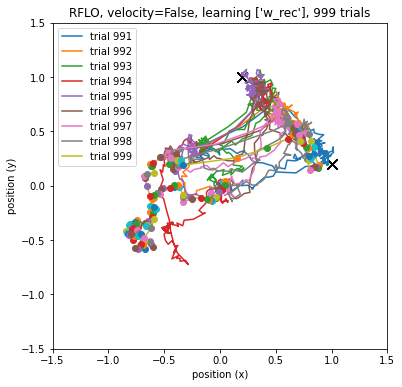

In [8]:

# Set RNN Parameters
params = RNNparams(n_in=2,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.01,sig_out=0.01,
               velocity_transform=False,
               rng=np.random.RandomState(1))

# Initialize RNN
net = RNN(params)

task = pds[0].batch_generator()

# initialize simulation
sim = Simulation(net)

""" Instantiate learning algorithm """
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec'],online=True) 


plt.figure(figsize=(6,6))

for i in range(1000):

    task_tup = x, y, mask, _ = next(task)
    sim.run_trial(task_tup,learn_alg=[rflo],probe_types=['h','y_out','pos', 'loss'],train=True)
    #if i % 10 == 0:

    if i > 990:
        plt.plot(sim.probes['pos'].squeeze()[:,0],sim.probes['pos'].squeeze()[:,1],label='trial {}'.format(i))
        plt.scatter(y[0,-1,0],y[0,-1,1],s=100,marker='x',color='k')

    



plt.plot([sim.probes['pos'].squeeze()[:,0]],[sim.probes['pos'].squeeze()[:,1]],'o')
plt.title('RFLO, velocity={}, learning {}, {} trials'.format(net.velocity_transform,rflo.apply_to,i))
plt.scatter(y[0,0,:],y[0,1,:],s=100,marker='x',color='k')
plt.scatter(0,0,s=100,marker='x',color='k')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel('position (x)')
plt.ylabel('position (y)')
plt.legend()
plt.show()

In [11]:
task_tup = x,y,mask,_=next(task)
sim.run_trial(task_tup,probe_types=['h','pos', 'loss'],train=True, learn_alg=[rflo])

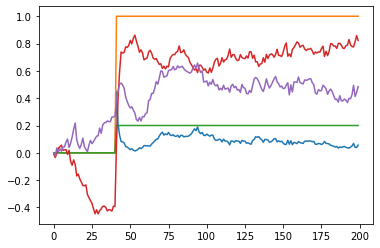

In [12]:
plt.plot(sim.probes['loss'])


# plt.plot(mask[0])
plt.plot(y[0])
# plt.plot(x[0])

plt.plot(sim.probes['pos'].squeeze()[:,0])
plt.plot(sim.probes['pos'].squeeze()[:,1])


### Train RNN on four targets using RFLO

trial_duration = 20
n_in=4
frac_on = 0.5

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

n_in: 2
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.01
sig_out: 0.01
tau_rec: 5
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: RandomState(MT19937)
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


/Users/jasminestone/GitRepos/rnn-learning/psychrnn-testing/../utils/plotting.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels)


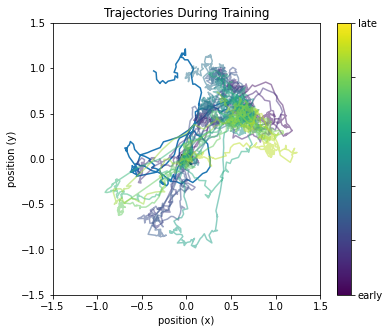

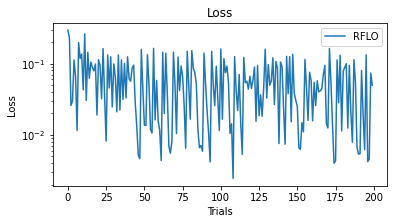

In [5]:
# Set RNN Parameters
params = RNNparams(n_in=2,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.01,sig_out=0.01,
               velocity_transform=False,
               rng=np.random.RandomState(1))
params.print_params()

# Initialize RNN
net = RNN(params)


# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec','w_out'],online=True) 

sim.run_session(n_trials=200, curriculum=curriculum, curriculum_test_size=10, learn_alg=[rflo], probe_types=['h','y_out','pos'],train=True,  plot=True, plot_freq=10)


In [15]:
curriculum.get_generator_function()


2

In [16]:
x,y,mask, _ = next(curriculum.get_generator_function())
sim.run_trial(task_tup,probe_types=['h','pos', 'loss'],train=True, learn_alg=[rflo])

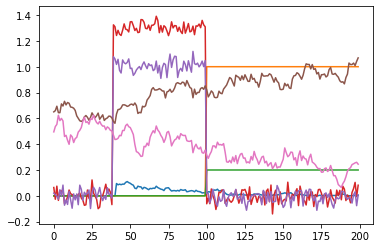

In [18]:
plt.plot(sim.probes['loss'])


# plt.plot(mask[0])
plt.plot(y[0])
plt.plot(x[0])

plt.plot(sim.probes['pos'].squeeze()[:,0])
plt.plot(sim.probes['pos'].squeeze()[:,1])

We can also plot the trained trajectories

In [ ]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4]) # TODO make this stuff possible again


NameError: name 'task1' is not defined